In [1]:
import pandas as pd
import preprocess
import network
import networkx as nx
import matplotlib.pyplot as plt
import math
import numpy as np
np.math = math
from idtxl.data import Data
from idtxl.multivariate_te import MultivariateTE
from idtxl.visualise_graph import plot_network
import pickle

# Define assets and file paths
assets = ["commodity", "credit", "currency", "energy", "equity", "interest", "metals", "real_estate", "volatility"]
file_paths = {asset: f"../data/{asset}_data.xlsx" for asset in assets}

# Load data
aligned_data, tickers = preprocess.load_and_align_data(file_paths)

# Drop tickers with many missing points
aligned_data, tickers = preprocess.drop_short_tickers(aligned_data, tickers, max_nan=50)
aligned_data['GB03'] + 0.1

# Compute log returns
log_returns = preprocess.compute_log_returns(aligned_data)

# Interest data has negative and zero values
# interest_data = aligned_data[tickers['interest']]
# log_returns[tickers["interest"]] = interest_data

# Drop NA
log_returns = log_returns.dropna()

abs_log_returns = np.abs(log_returns)

Tickers to drop/replace due to insufficient data:
['FXJPEMCS', 'QCLN']


c:\Users\akhma\OneDrive\Onenote\Python\my_venv\Lib\site-packages\pandas\core\internals\blocks.py:393: RuntimeWarning:

invalid value encountered in log



In [2]:
def idtxl_te_values(results):
    n_nodes = len(results.targets_analysed)
    te_matrix = np.zeros((n_nodes, n_nodes))

    for target in results.targets_analysed:
        res = results.get_single_target(target, fdr=False)

        te_vals = res["selected_sources_te"]
        if te_vals is None:
            continue
        
        sources = [src for src, _ in res["selected_vars_sources"]]

        for src, te in zip(sources, te_vals):
            te_matrix[src, target] = te
    
    return te_matrix

def idtxl_3d_te_matrix(windows_results):
    n_nodes = len(windows_results[0].targets_analysed)
    n_windows = len(windows_results)

    te_matrix_3d = np.zeros((n_nodes, n_nodes, n_windows))

    for t, results in enumerate(windows_results):
        te_matrix_3d[:, :, t] = idtxl_te_values(results)

    return te_matrix_3d

def adj_matrix_to_graph(data, adj_matrix):
    node_labels = data.columns
    G = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)
    mapping = {i: name for i, name in enumerate(node_labels)}
    G = nx.relabel_nodes(G, mapping)
    return G

In [4]:
def pca_df(dataframe, tickers):
    pca_asset_classes = {}
    explained_variance_ratios = {}
    asset_classes = tickers.keys()
    for asset_class in asset_classes:
        vals = dataframe[tickers[asset_class]]
        pca, pca_components, explained_variance_ratio = preprocess.compute_pca(vals)
        explained_variance_ratios[asset_class] = explained_variance_ratio
        X = pca_components[:, 0]  # Take first principal component
        pca_asset_classes[asset_class] = X
    
    dates = dataframe.index
    pca_asset_classes = pd.DataFrame(pca_asset_classes)
    pca_asset_classes.index = dates
    pca_asset_classes.index = pd.to_datetime(pca_asset_classes.index)

    return pca_asset_classes

In [5]:
pca_asset_classes = pca_df(log_returns, tickers)

In [6]:
pca_asset_classes

,commodity,credit,currency,energy,equity,interest,metals,real_estate,volatility
Date,,,,,,,,,
2005-01-04,-4.088475,-1.769011,4.452369,0.445588,-3.020046,1.029952,-0.896389,-1.265406,0.252375
2005-01-05,0.519150,0.086436,0.043246,-0.689898,-1.605163,-0.015289,-0.093783,-2.853041,0.140871
2005-01-06,-1.371624,-0.159507,2.164045,1.928206,0.209915,-0.361726,-0.908315,0.443454,-0.376768
2005-01-07,2.381578,-0.059961,1.132001,-0.333218,-0.529228,0.210705,-0.127772,0.485471,-0.627939
2005-01-10,0.890050,0.250446,-0.888319,0.398863,0.772065,0.119725,0.280258,-0.112006,0.084147
...,...,...,...,...,...,...,...,...,...
2024-11-12,-3.383761,-3.289233,3.077290,-0.918563,-0.311495,1.039234,-4.078478,-1.831145,0.003735
2024-11-13,-0.389117,-1.314776,1.260705,0.399097,-0.676311,-0.067541,-0.805149,-0.017131,-0.848051
2024-11-14,-1.169418,0.110901,0.746317,0.257160,-1.546428,0.128893,-0.103956,-0.265954,0.321262


In [7]:
def idtxl_multi_te(data, settings):
    data_array = data.to_numpy()
    data_array = data_array - data_array.min()  # shift labels to start at 0
    data_array = np.expand_dims(data_array, axis=2)

    data = Data(normalise=False)
    data.set_data(data_array, dim_order='spr')

    network_analysis = MultivariateTE()

    results = network_analysis.analyse_network(settings=settings, data=data)

    results.print_edge_list(weights="max_te_lag", fdr=False)
    plot_network(results=results, weights="max_te_lag", fdr=False)
    plt.show()

    return results
def windows_multi_te(windows, settings):
    windows_results = []
    for (_, _, window_data) in windows:
        results = idtxl_multi_te(data=window_data, settings=settings)
        windows_results.append(results)
    return windows_results

Adding data with properties: 9 processes, 4860 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200


C:\Users\akhma\OneDrive\Onenote\Python\IDTxl\idtxl\data.py:274: RuntimeWarning:

invalid value encountered in cast



testing candidate: (0, 3) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, np.int64(1)), (1, np.int64(2)), (1, np.int64(3)), (1, np.int64(4)), (1, np.int64(5)), (2, np.int64(1)), (2, np.int64(2)), (2, np.int64(3)), (2, np.int64(4)), (2, np.int64(5)), (3, np.int64(1)), (3, np.int64(2)), (3, np.int64(3)), (3, np.int64(4)), (3, np.int64(5)), (4, np.int64(1)), (4, np.int64(2)), (4, np.int64(3)), (4, np.int64(4)), (4, np.int64(5)), (5, np.int64(1)), (5, np.int64(2)), (5, np.int64(3)), (5, np.int64(4)), (5, np.int64(5)), (6, np.int64(1)), (6, np.int64(2)), (6, np.int64(3)), (6, np.int64(4)), (6, np.int64(5)), (7, np.int64(1)), (7, np.int64(2)), (7, np.int64(3)), (7, np.int64(4)), (7, np.int64(5)), (8, np.int64(1)), (8, np.int64(2)), (8, np.int64(3)), (8, np.int64(4)), (8, np.int64(5))]
testing candidate: (4, np.int64(1)) maximum statistic, n_perm: 200
testing candidate: (6, np.int64(1)) maximum statistic, n_per

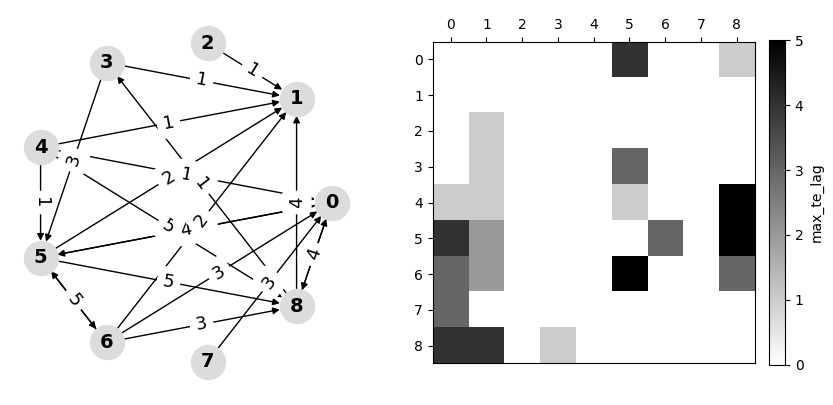

In [9]:
discrete_log_returns = preprocess.discretize_df(pca_asset_classes, num_bins=2)
settings = {
    "cmi_estimator": "JidtDiscreteCMI",
    "max_lag_sources": 5,
    "min_lag_sources": 1,
    "n_discrete_bins": np.max(discrete_log_returns) + 1 
}
results = idtxl_multi_te(discrete_log_returns, settings=settings)

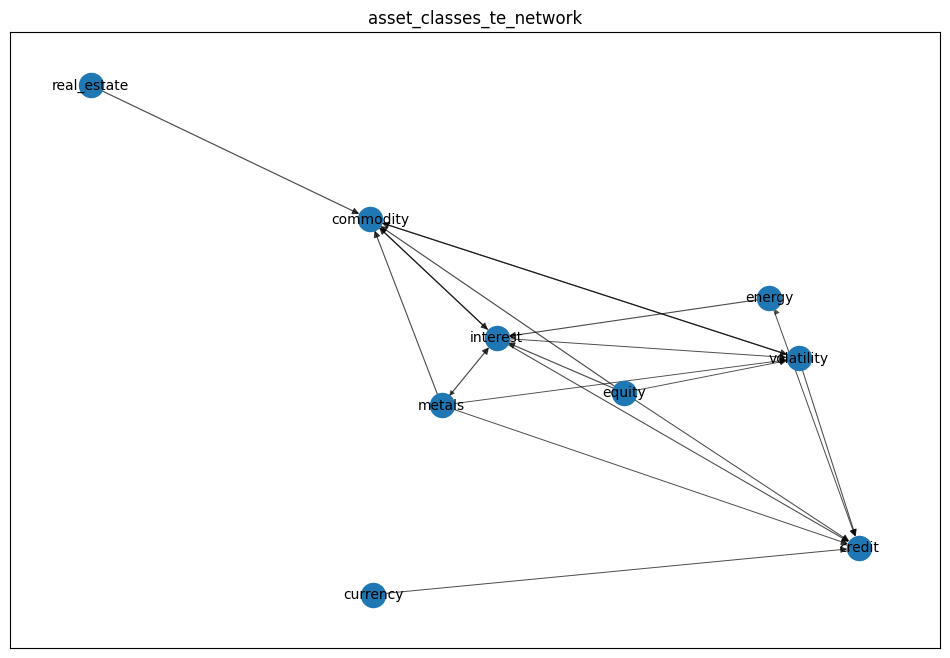

In [10]:
te_matrix = idtxl_te_values(results)
G = adj_matrix_to_graph(pca_asset_classes, te_matrix)
largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
G_largest_cc = G.subgraph(largest_cc).copy()
fixed_pos = nx.spring_layout(G_largest_cc, seed=21)
network.plot_graph(G_largest_cc, fixed_pos, "asset_classes_te_network")

In [19]:
def network_properties(G):

    analysis = {}

    in_degrees = dict(G.in_degree(weight="weight"))
    out_degrees = dict(G.out_degree(weight="weight"))
    analysis['in_degree'] = pd.Series(in_degrees)
    analysis['out_degree'] = pd.Series(out_degrees)
    analysis['betweenness_centr'] = nx.betweenness_centrality(G, weight="weight")
    analysis['e_vector_centr'] = nx.eigenvector_centrality(G, weight="weight")
    analysis['clustering'] = nx.clustering(G, weight="weight")
    return pd.DataFrame(analysis)

Adding data with properties: 9 processes, 4860 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200


C:\Users\akhma\OneDrive\Onenote\Python\IDTxl\idtxl\data.py:274: RuntimeWarning:

invalid value encountered in cast



testing candidate: (0, 2) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(1, np.int64(1)), (1, np.int64(2)), (1, np.int64(3)), (1, np.int64(4)), (1, np.int64(5)), (2, np.int64(1)), (2, np.int64(2)), (2, np.int64(3)), (2, np.int64(4)), (2, np.int64(5)), (3, np.int64(1)), (3, np.int64(2)), (3, np.int64(3)), (3, np.int64(4)), (3, np.int64(5)), (4, np.int64(1)), (4, np.int64(2)), (4, np.int64(3)), (4, np.int64(4)), (4, np.int64(5)), (5, np.int64(1)), (5, np.int64(2)), (5, np.int64(3)), (5, np.int64(4)), (5, np.int64(5)), (6, np.int64(1)), (6, np.int64(2)), (6, np.int64(3)), (6, np.int64(4)), (6, np.int64(5)), (7, np.int64(1)), (7, np.int64(2)), (7, np.int64(3)), (7, np.int64(4)), (7, np.int64(5)), (8, np.int64(1)), (8, np.int64(2)), (8, np.int64(3)), (8, np.int64

C:\Users\akhma\OneDrive\Onenote\Python\IDTxl\idtxl\network_inference.py:1015: RuntimeWarning:

invalid value encountered in cast



final source samples: [(5, np.int64(3)), (5, np.int64(5))]
final target samples: [(2, 5), (2, 3), (2, 2), (2, 4), (2, 1)]



####### analysing target with index 3 from list [0, 1, 2, 3, 4, 5, 6, 7, 8]

Target: 3 - testing sources [0, 1, 2, 4, 5, 6, 7, 8]

---------------------------- (1) include target candidates
candidate set: [(3, 1), (3, 2), (3, 3), (3, 4), (3, 5)]
testing candidate: (3, 1) 
maximum statistic, n_perm: 200
testing candidate: (3, 5) maximum statistic, n_perm: 200
testing candidate: (3, 3) maximum statistic, n_perm: 200
testing candidate: (3, 4) maximum statistic, n_perm: 200
testing candidate: (3, 2) maximum statistic, n_perm: 200

---------------------------- (2) include source candidates
candidate set: [(0, np.int64(1)), (0, np.int64(2)), (0, np.int64(3)), (0, np.int64(4)), (0, np.int64(5)), (1, np.int64(1)), (1, np.int64(2)), (1, np.int64(3)), (1, np.int64(4)), (1, np.int64(5)), (2, np.int64(1)), (2, np.int64(2)), (2, np.int64(3)), (2, np.int64(4)), (2, np.int64(5)

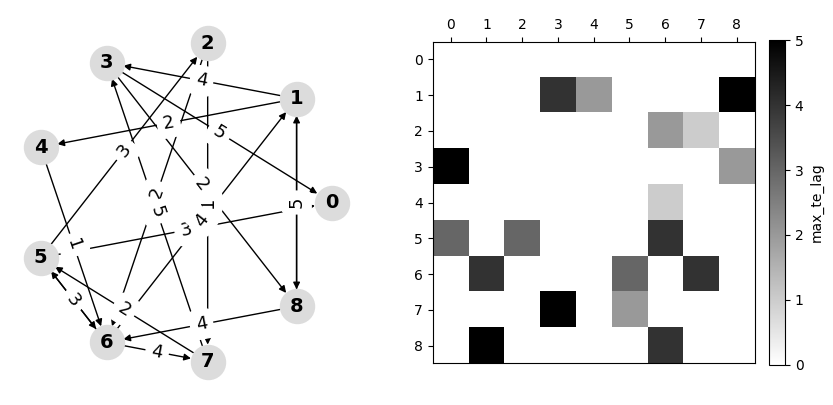

In [11]:
discrete_log_returns = preprocess.discretize_df(pca_asset_classes, num_bins=3)
settings = {
    "cmi_estimator": "JidtDiscreteCMI",
    "max_lag_sources": 5,
    "min_lag_sources": 1,
    "n_discrete_bins": np.max(discrete_log_returns) + 1 
}
results = idtxl_multi_te(discrete_log_returns, settings=settings)

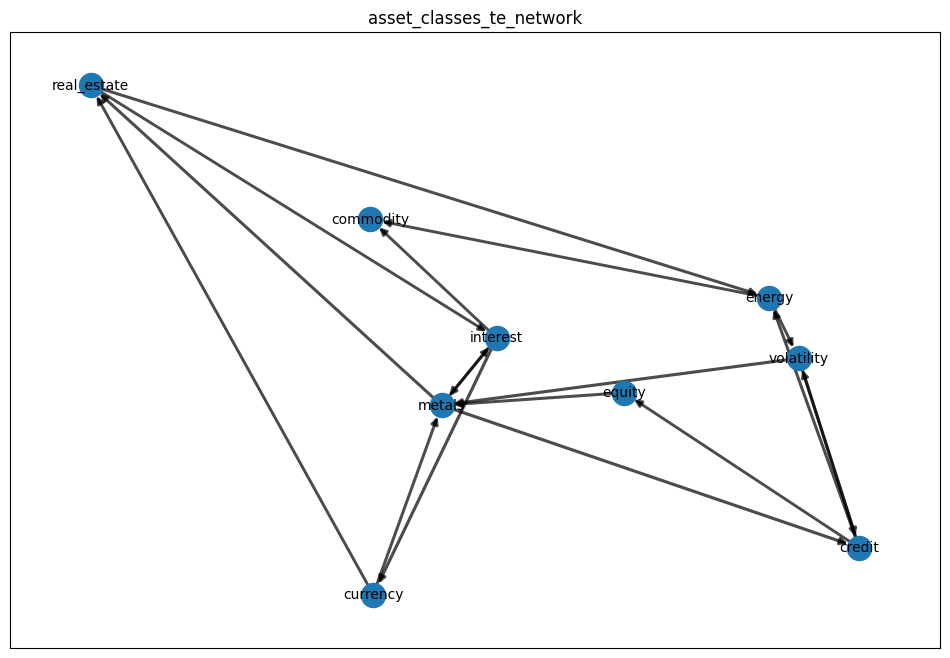

In [12]:
te_matrix = idtxl_te_values(results)
G = adj_matrix_to_graph(pca_asset_classes, te_matrix)
largest_cc = max(nx.connected_components(G.to_undirected()), key=len)
G_largest_cc = G.subgraph(largest_cc).copy()
network.plot_graph(G_largest_cc, fixed_pos, "asset_classes_te_network")

Adding data with properties: 9 processes, 1477 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, np.int64(1)), (1, np.int64(2)), (1, np.int64(3)), (1, np.int64(4)), (1, np.int64(5)), (2, np.int64(1)), (2, np.int64(2)), (2, np.int64(3)), (2, np.int64(4)), (2, np.int64(5)), (3, np.int64(1)), (3, np.int64(2)), (3, np.int64(3)), (3, np.int64(4)), (3, np.int64(5)), (4, np.int64(1)), (4, np.int64(2)), (4, np.int64(3)), (4, np.int64(4)), (4, np.int64(5)), (5, np.int64(1)), (5, np.int64(2)), (5, np.int64(3)), (5, np.int64(4)), (5, np.int64(

C:\Users\akhma\OneDrive\Onenote\Python\IDTxl\idtxl\data.py:274: RuntimeWarning:

invalid value encountered in cast



testing candidate: (2, np.int64(2)) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (3) prune source candidate
selected candidates: [(4, np.int64(1))]
 -- significant

---------------------------- (4) final statistics
selected variables: [(0, 1), (4, np.int64(1))]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500, testing 1 selected sources
removing 0 variables after seq. max stats
final source samples: [(4, np.int64(1))]
final target samples: [(0, 1)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 2) 
maximum statistic, n_perm: 200
 -- not significant

No informative sources in the target's past - adding target sample with lag 1.

---------------------------- (2) include source candidates
candidat

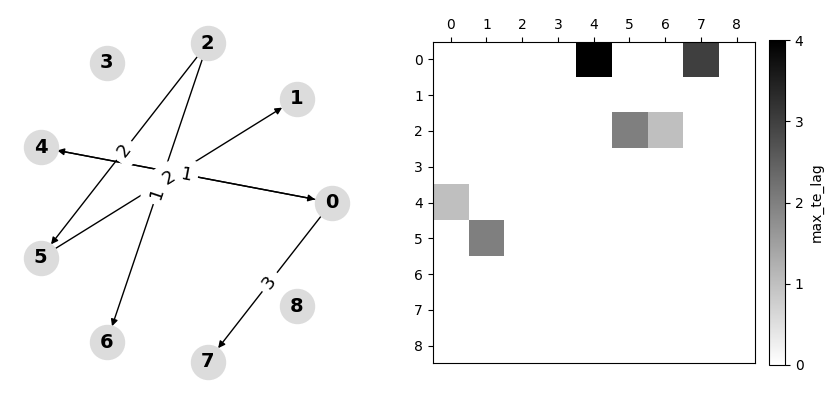

Adding data with properties: 9 processes, 1443 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
testing candidate: (0, 3) maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, np.int64(1)), (1, np.int64(2)), (1, np.int64(3)), (1, np.int64(4)), (1, np.int64(5)), (2, np.int64(1)), (2, np.int64(2)), (2, np.int64(3)), (2, np.int64(4)), (2, np.int64(5)), (3, np.int64(1)), (3, np.int64(2)), (3, np.int64(3)), (3, np.int64(4)), (3, np.int64(5)), (4, np.int64(1)), (4, np.int64(2)), (4, np.int64(3)), (4, np.

C:\Users\akhma\OneDrive\Onenote\Python\IDTxl\idtxl\network_inference.py:1022: RuntimeWarning:

invalid value encountered in cast

C:\Users\akhma\OneDrive\Onenote\Python\IDTxl\idtxl\stats.py:553: RuntimeWarning:

invalid value encountered in cast



final source samples: [(7, np.int64(1)), (3, np.int64(1)), (5, np.int64(5)), (2, np.int64(5)), (8, np.int64(2)), (5, np.int64(4))]
final target samples: [(0, 1), (0, 4), (0, 3)]



####### analysing target with index 1 from list [0, 1, 2, 3, 4, 5, 6, 7, 8]

Target: 1 - testing sources [0, 2, 3, 4, 5, 6, 7, 8]

---------------------------- (1) include target candidates
candidate set: [(1, 1), (1, 2), (1, 3), (1, 4), (1, 5)]
testing candidate: (1, 2) 
maximum statistic, n_perm: 200
 -- not significant

No informative sources in the target's past - adding target sample with lag 1.

---------------------------- (2) include source candidates
candidate set: [(0, np.int64(1)), (0, np.int64(2)), (0, np.int64(3)), (0, np.int64(4)), (0, np.int64(5)), (2, np.int64(1)), (2, np.int64(2)), (2, np.int64(3)), (2, np.int64(4)), (2, np.int64(5)), (3, np.int64(1)), (3, np.int64(2)), (3, np.int64(3)), (3, np.int64(4)), (3, np.int64(5)), (4, np.int64(1)), (4, np.int64(2)), (4, np.int64(3)), (4, np.int64(4)

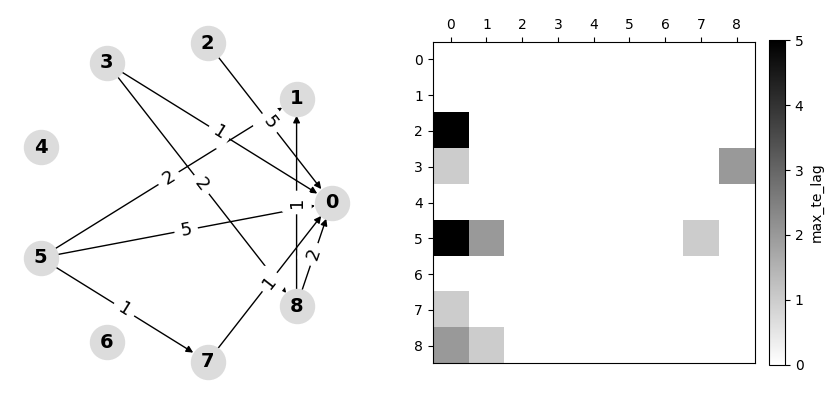

Adding data with properties: 9 processes, 1435 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, np.int64(1)), (1, np.int64(2)), (1, np.int64(3)), (1, np.int64(4)), (1, np.int64(5)), (2, np.int64(1)), (2, np.int64(2)), (2, np.int64(3)), (2, np.int64(4)), (2, np.int64(5)), (3, np.int64(1)), (3, np.int64(2)), (3, np.int64(3)), (3, np.int64(4)), (3, np.int64(5)), (4, np.int64(1)), (4, np.int64(2)), (4, np.int64(3)), (4, np.int64(4)), (4, np.int64(5)), (5, np.int64(1)), (5, np.int64(2)), (5, np.int64(3)), (5, np.int64(4)), (5, np.int64(

C:\Users\akhma\OneDrive\Onenote\Python\IDTxl\idtxl\network_inference.py:1015: RuntimeWarning:

invalid value encountered in cast



testing candidate: (6, np.int64(2)) minimum statistic, n_perm: 500
 -- significant

---------------------------- (4) final statistics
selected variables: [(8, 1), (4, np.int64(2)), (0, np.int64(3)), (0, np.int64(4)), (0, np.int64(5)), (5, np.int64(1)), (6, np.int64(1)), (3, np.int64(3)), (6, np.int64(2))]
omnibus test, n_perm: 500
 -- significant

sequential maximum statistic, n_perm: 500, testing 8 selected sources
removing 0 variables after seq. max stats
final source samples: [(4, np.int64(2)), (0, np.int64(3)), (0, np.int64(4)), (0, np.int64(5)), (5, np.int64(1)), (6, np.int64(1)), (3, np.int64(3)), (6, np.int64(2))]
final target samples: [(8, 1)]


	0 -> 8, max_te_lag: 5
	1 -> 2, max_te_lag: 5
	2 -> 0, max_te_lag: 1
	3 -> 8, max_te_lag: 3
	4 -> 1, max_te_lag: 2
	4 -> 8, max_te_lag: 2
	5 -> 1, max_te_lag: 3
	5 -> 7, max_te_lag: 5
	5 -> 8, max_te_lag: 1
	6 -> 1, max_te_lag: 4
	6 -> 8, max_te_lag: 1
	7 -> 3, max_te_lag: 1
	7 -> 6, max_te_lag: 5
	8 -> 1, max_te_lag: 1


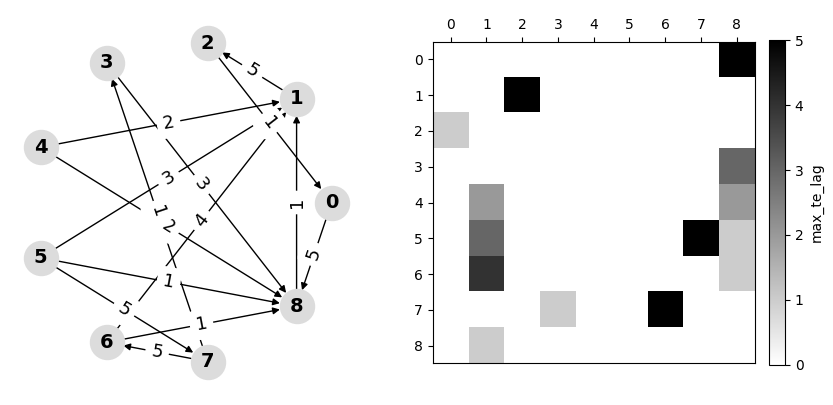

Adding data with properties: 9 processes, 1471 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
testing candidate: (0, 5) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, np.int64(1)), (1, np.int64(2)), (1, np.int64(3)), (1, np.int64(4)), (1, np.int64(5)), (2, np.int64(1)), (2, np.int64(2)), (2, np.int64(3)), (2, np.int64(4)), (2, np.int64(5)), (3, np.int64(1)), (3, np.int64(2)), (3, np.int64(3)), (3, np.int64(4)), (3, np.int64(5)), (4, np.int64(1)), (4, np.int64(2)), (4, np.int64(3)), (4, np.int64(4)), (4, np.int64(5)), (5, np.int64(1)), (5, np.int

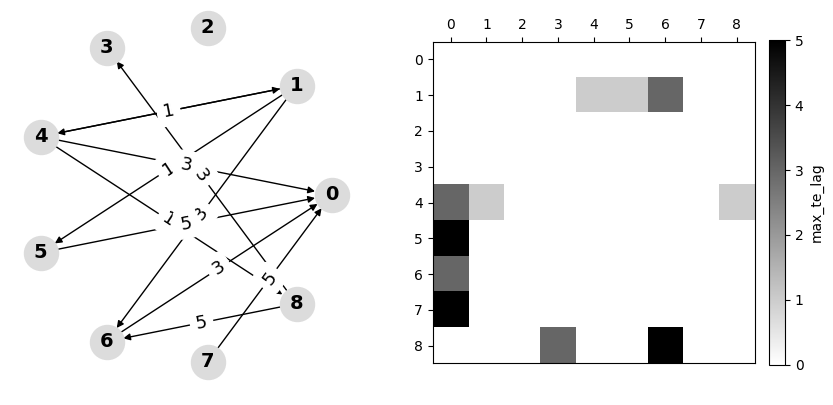

Adding data with properties: 9 processes, 1493 samples, 1 replications
overwriting existing data

####### analysing target with index 0 from list [0, 1, 2, 3, 4, 5, 6, 7, 8]

Target: 0 - testing sources [1, 2, 3, 4, 5, 6, 7, 8]

---------------------------- (1) include target candidates
candidate set: [(0, 1), (0, 2), (0, 3), (0, 4), (0, 5)]
testing candidate: (0, 1) 
maximum statistic, n_perm: 200
testing candidate: (0, 2) maximum statistic, n_perm: 200
testing candidate: (0, 4) maximum statistic, n_perm: 200
 -- not significant

---------------------------- (2) include source candidates
candidate set: [(1, np.int64(1)), (1, np.int64(2)), (1, np.int64(3)), (1, np.int64(4)), (1, np.int64(5)), (2, np.int64(1)), (2, np.int64(2)), (2, np.int64(3)), (2, np.int64(4)), (2, np.int64(5)), (3, np.int64(1)), (3, np.int64(2)), (3, np.int64(3)), (3, np.int64(4)), (3, np.int64(5)), (4, np.int64(1)), (4, np.int64(2)), (4, np.int64(3)), (4, np.int64(4)), (4, np.int64(5)), (5, np.int64(1)), (5, np.int

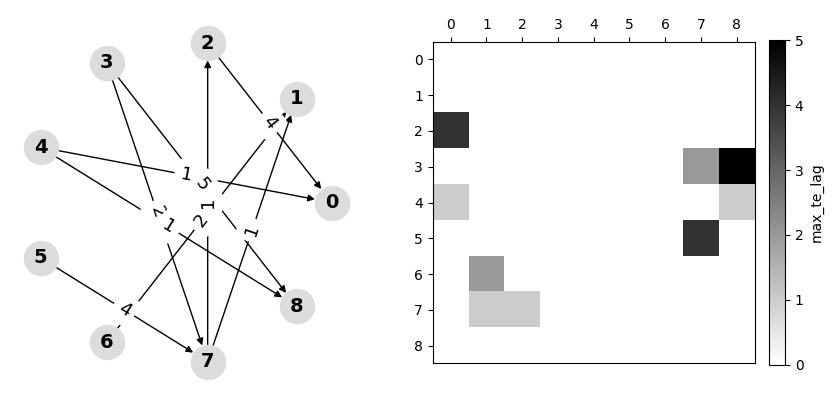

In [13]:
discrete_log_returns = preprocess.discretize_df(pca_asset_classes, num_bins=2)
window_len = 6
window_step = 3
windows = preprocess.sliding_window(discrete_log_returns, 
                                    window_len, 
                                    window_step, 
                                    window_unit="years", 
                                    step_unit="years")
endpoints = [end_date for _, end_date, _ in windows]

settings = {
    "cmi_estimator": "JidtDiscreteCMI",
    "max_lag_sources": 5,
    "min_lag_sources": 1,
    "n_discrete_bins": np.max(discrete_log_returns) + 1 
}

windows_results = windows_multi_te(windows, settings)

In [16]:
import plotly.graph_objects as go
def create_measure_heatmap(measure_matrix, assets, endpoints, 
                         measure_name="measure", window_len="2", colorscale="Viridis"):
    num_windows = measure_matrix.shape[2]
    
    frames = [
        go.Frame(
            name=f"Window {t}",
            data=go.Heatmap(
                z=measure_matrix[:, :, t],
                x=assets,
                y=assets,
                colorscale=colorscale,
                # Ensure square aspect ratio
                hoverongaps=False,
                showscale=True
            )
        )
        for t in range(num_windows)
    ]
    
    slider_steps = [{
        "args": [[f"Window {t}"], {"frame": {"duration": 0}, "mode": "immediate"}],
        "label": str(endpoints[t].year),
        "method": "animate"
    } for t in range(num_windows)]
    
    fig = go.Figure(
        data=frames[0].data,
        frames=frames,
        layout=go.Layout(
            title=f"{measure_name} Heatmap Over Time",
            sliders=[{
                "active": 0,
                "steps": slider_steps,
                "currentvalue": {
                    "font": {"size": 20},
                    "prefix": f"{window_len} Year(s) up to: ", 
                    "xanchor": "right"},
                "pad": {"b": 10, "t": 50}
            }],
            # Add these layout adjustments
            height=800,  # Increase height
            margin=dict(l=120),  # Add left margin for labels
            yaxis=dict(
                tickangle=-45,  # Rotate labels
                tickfont=dict(size=10)  # Smaller font
            ),
            xaxis=dict(
                tickangle=45,
                tickfont=dict(size=10)
            )
        )
    )
    return fig

In [14]:
te_matrix_3d = idtxl_3d_te_matrix(windows_results)

In [18]:
create_measure_heatmap(te_matrix_3d, 
                        pca_asset_classes.columns, 
                        endpoints, 
                        window_len=6,
                        measure_name="Multivariate Transfer Entropy")